# Auxiliary Classifier Generative Adversarial Networks


The generative adversarial network is an architecture for training a generative model, typically deep convolutional neural networks for generating image.

The architecture is comprised of both a generator model that takes random points from a latent space as input and generates images, and a discriminator for classifying images as either real (from the dataset) or fake (generate). Both models are then trained simultaneously in a zero-sum game.

A conditional GAN, cGAN or CGAN for short, is an extension of the GAN architecture that adds structure to the latent space. The training of the GAN model is changed so that the generator is provided both with a point in the latent space and a class label as input, and attempts to generate an image for that class. The discriminator is provided with both an image and the class label and must classify whether the image is real or fake as before.

The addition of the class as input makes the image generation process, and image classification process, conditional on the class label, hence the name. The effect is both a more stable training process and a resulting generator model that can be used to generate images of a given specific type, e.g. for a class label.

The Auxiliary Classifier GAN, or AC-GAN for short, is a further extension of the GAN architecture building upon the CGAN extension. It was introduced by Augustus Odena, et al. from Google Brain in the 2016 paper titled “Conditional Image Synthesis with Auxiliary Classifier GANs.”

As with the conditional GAN, the generator model in the AC-GAN is provided both with a point in the latent space and the class label as input, e.g. the image generation process is conditional.

The main difference is in the discriminator model, which is only provided with the image as input, unlike the conditional GAN that is provided with the image and class label as input. The discriminator model must then predict whether the given image is real or fake as before, and must also predict the class label of the image.

The architecture is described in such a way that the discriminator and auxiliary classifier may be considered separate models that share model weights. In practice, the discriminator and auxiliary classifier can be implemented as a single neural network model with two outputs.

The first output is a single probability via the sigmoid activation function that indicates the “realness” of the input image and is optimized using binary cross entropy like a normal GAN discriminator model.

The second output is a probability of the image belonging to each class via the softmax activation function, like any given multi-class classification neural network model, and is optimized using categorical cross entropy.

Using TensorFlow backend.


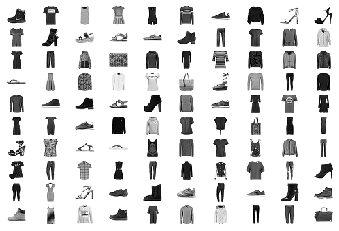

In [1]:
from keras.datasets.fashion_mnist import load_data
from matplotlib import pyplot
# load the images into memory
(trainX, trainy), (testX, testy) = load_data()
# plot images from the training dataset
for i in range(100):
	# define subplot
	pyplot.subplot(10, 10, 1 + i)
	# turn off axis
	pyplot.axis('off')
	# plot raw pixel data
	pyplot.imshow(trainX[i], cmap='gray_r')
pyplot.show()

The Fashion-MNIST dataset is proposed as a more challenging replacement dataset for the MNIST handwritten digit dataset.

It is a dataset comprised of 60,000 small square 28×28 pixel grayscale images of items of 10 types of clothing, such as shoes, t-shirts, dresses, and more.

Keras provides access to the Fashion-MNIST dataset via the fashion_mnist.load_dataset() function. It returns two tuples, one with the input and output elements for the standard training dataset, and another with the input and output elements for the standard test dataset.

In [ ]:
from numpy import zeros
from numpy import ones
from numpy import expand_dims
from numpy.random import randn
from numpy.random import randint
from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Activation
from keras.layers import Concatenate
from keras.initializers import RandomNormal
from matplotlib import pyplot

The discriminator model must take as input an image and predict both the probability of the ‘realness‘ of the image and the probability of the image belonging to each of the given classes.

The input images will have the shape 28x28x1 and there are 10 classes for the items of clothing in the Fashion MNIST dataset.

The model can be defined as per the DCGAN architecture. That is, using Gaussian weight initialization, batch normalization, LeakyReLU, Dropout, and a 2×2 stride for downsampling instead of pooling layers.

The model must be trained with two loss functions, binary cross entropy for the first output layer, and categorical cross-entropy loss for the second output layer.

Rather than comparing a one hot encoding of the class labels to the second output layer, as we might do normally, we can compare the integer class labels directly. We can achieve this automatically using the sparse categorical cross-entropy loss function. This will have the identical effect of the categorical cross-entropy but avoids the step of having to manually one hot encode the target labels.

When compiling the model, we can inform Keras to use the two different loss functions for the two output layers by specifying a list of function names as strings.



The generator model must take a random point from the latent space as input, and the class label, then output a generated grayscale image with the shape 28x28x1.

The AC-GAN paper describes the AC-GAN generator model taking a vector input that is a concatenation of the point in latent space (100 dimensions) and the one hot encoded class label (10 dimensions) that is 110 dimensions.

An alternative approach that has proven effective and is now generally recommended is to interpret the class label as an additional channel or feature map early in the generator model.

This can be achieved by using a learned embedding with an arbitrary number of dimensions (e.g. 50), the output of which can be interpreted by a fully connected layer with a linear activation resulting in one additional 7×7 feature map.

The point in latent space can be interpreted by a fully connected layer with sufficient activations to create multiple 7×7 feature maps, in this case, 384, and provide the basis for a low-resolution version of our output image.

The 7×7 single feature map interpretation of the class label can then be channel-wise concatenated, resulting in 385 feature maps.

These feature maps can then go through the process of two transpose convolutional layers to upsample the 7×7 feature maps first to 14×14 pixels, and then finally to 28×28 features, quadrupling the area of the feature maps with each upscaling step.

The output of the generator is a single feature map or grayscale image with the shape 28×28 and pixel values in the range [-1, 1] given the choice of a tanh activation function. We use ReLU activation for the upscaling layers instead of LeakyReLU given the suggestion the AC-GAN paper.

We can tie all of this together and into the define_generator() function defined below that will create and return the generator model for the AC-GAN.

The model is intentionally not compiled as it is not trained directly; instead, it is trained via the discriminator model.


In [ ]:
# define the standalone generator model
def define_generator(latent_dim, n_classes=10):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# label input
	in_label = Input(shape=(1,))
	# embedding for categorical input
	li = Embedding(n_classes, 50)(in_label)
	# linear multiplication
	n_nodes = 7 * 7
	li = Dense(n_nodes, kernel_initializer=init)(li)
	# reshape to additional channel
	li = Reshape((7, 7, 1))(li)
	# image generator input
	in_lat = Input(shape=(latent_dim,))
	# foundation for 7x7 image
	n_nodes = 384 * 7 * 7
	gen = Dense(n_nodes, kernel_initializer=init)(in_lat)
	gen = Activation('relu')(gen)
	gen = Reshape((7, 7, 384))(gen)
	# merge image gen and label input
	merge = Concatenate()([gen, li])
	# upsample to 14x14
	gen = Conv2DTranspose(192, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(merge)
	gen = BatchNormalization()(gen)
	gen = Activation('relu')(gen)
	# upsample to 28x28
	gen = Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(gen)
	out_layer = Activation('tanh')(gen)
	# define model
	model = Model([in_lat, in_label], out_layer)
	return model

The generator model is not updated directly; instead, it is updated via the discriminator model.

This can be achieved by creating a composite model that stacks the generator model on top of the discriminator model.

The input to this composite model is the input to the generator model, namely a random point from the latent space and a class label. The generator model is connected directly to the discriminator model, which takes the generated image directly as input. Finally, the discriminator model predicts both the realness of the generated image and the class label. As such, the composite model is optimized using two loss functions, one for each output of the discriminator model.

The discriminator model is updated in a standalone manner using real and fake examples, and we will review how to do this in the next section. Therefore, we do not want to update the discriminator model when updating (training) the composite model; we only want to use this composite model to update the weights of the generator model.

This can be achieved by setting the layers of the discriminator as not trainable prior to compiling the composite model. This only has an effect on the layer weights when viewed or used by the composite model and prevents them from being updated when the composite model is updated.

The define_gan() function below implements this, taking the already defined generator and discriminator models as input and defining a new composite model that can be used to update the generator model only.

In [ ]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect the outputs of the generator to the inputs of the discriminator
	gan_output = d_model(g_model.output)
	# define gan model as taking noise and label and outputting real/fake and label outputs
	model = Model(g_model.input, gan_output)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
	return model

We only require the images in the training dataset. The images are black and white, therefore we must add an additional channel dimension to transform them to be three dimensional, as expected by the convolutional layers of our models. Finally, the pixel values must be scaled to the range [-1,1] to match the output of the generator model.

The load_real_samples() function below implements this, returning the loaded and scaled Fashion MNIST training dataset ready for modeling.

In [ ]:
# load images
def load_real_samples():
	# load dataset
	(trainX, trainy), (_, _) = load_data()
	# expand to 3d, e.g. add channels
	X = expand_dims(trainX, axis=-1)
	# convert from ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	print(X.shape, trainy.shape)
	return [X, trainy]

We will require one batch (or a half batch) of real images from the dataset each update to the GAN model. A simple way to achieve this is to select a random sample of images from the dataset each time.

The generate_real_samples() function below implements this, taking the prepared dataset as an argument, selecting and returning a random sample of Fashion MNIST images and clothing class labels.

The “dataset” argument provided to the function is a list comprised of the images and class labels as returned from the load_real_samples() function. The function also returns their corresponding class label for the discriminator, specifically class=1 indicating that they are real images.

In [ ]:
# select real samples
def generate_real_samples(dataset, n_samples):
	# split into images and labels
	images, labels = dataset
	# choose random instances
	ix = randint(0, images.shape[0], n_samples)
	# select images and labels
	X, labels = images[ix], labels[ix]
	# generate class labels
	y = ones((n_samples, 1))
	return [X, labels], y

Next, we need to use the points in the latent space and clothing class labels as input to the generator in order to generate new images.

The generate_fake_samples() function below implements this, taking the generator model and size of the latent space as arguments, then generating points in the latent space and using them as input to the generator model.

The function returns the generated images, their corresponding clothing class label, and their discriminator class label, specifically class=0 to indicate they are fake or generated.

In [ ]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]

In [ ]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	images = generator.predict([z_input, labels_input])
	# create class labels
	y = zeros((n_samples, 1))
	return [images, labels_input], y

There are no reliable ways to determine when to stop training a GAN; instead, images can be subjectively inspected in order to choose a final model.

Therefore, we can periodically generate a sample of images using the generator model and save the generator model to file for later use. The summarize_performance() function below implements this, generating 100 images, plotting them, and saving the plot and the generator to file with a filename that includes the training “step” number.

In [ ]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, latent_dim, n_samples=100):
	# prepare fake examples
	[X, _], _ = generate_fake_samples(g_model, latent_dim, n_samples)
	# scale from [-1,1] to [0,1]
	X = (X + 1) / 2.0
	# plot images
	for i in range(100):
		# define subplot
		pyplot.subplot(10, 10, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
	# save plot to file
	filename1 = 'generated_plot_%04d.png' % (step+1)
	pyplot.savefig(filename1)
	pyplot.close()
	# save the generator model
	filename2 = 'model_%04d.h5' % (step+1)
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

We are now ready to fit the GAN models.

The model is fit for 100 training epochs, which is arbitrary, as the model begins generating plausible items of clothing after perhaps 20 epochs. A batch size of 64 samples is used, and each training epoch involves 60,000/64, or about 937, batches of real and fake samples and updates to the model. The summarize_performance() function is called every 10 epochs, or every (937 * 10) 9,370 training steps.

For a given training step, first the discriminator model is updated for a half batch of real samples, then a half batch of fake samples, together forming one batch of weight updates. The generator is then updated via the combined GAN model. Importantly, the class label is set to 1, or real, for the fake samples. This has the effect of updating the generator toward getting better at generating real samples on the next batch.

Note, the discriminator and composite model return three loss values from the call to the train_on_batch() function. The first value is the sum of the loss values and can be ignored, whereas the second value is the loss for the real/fake output layer and the third value is the loss for the clothing label classification.

The train() function below implements this, taking the defined models, dataset, and size of the latent dimension as arguments and parameterizing the number of epochs and batch size with default arguments. The generator model is saved at the end of training.

In [ ]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=64):
	# calculate the number of batches per training epoch
	bat_per_epo = int(dataset[0].shape[0] / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# calculate the size of half a batch of samples
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_steps):
		# get randomly selected 'real' samples
		[X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
		# update discriminator model weights
		_,d_r1,d_r2 = d_model.train_on_batch(X_real, [y_real, labels_real])
		# generate 'fake' examples
		[X_fake, labels_fake], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
		# update discriminator model weights
		_,d_f,d_f2 = d_model.train_on_batch(X_fake, [y_fake, labels_fake])
		# prepare points in latent space as input for the generator
		[z_input, z_labels] = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = ones((n_batch, 1))
		# update the generator via the discriminator's error
		_,g_1,g_2 = gan_model.train_on_batch([z_input, z_labels], [y_gan, z_labels])
		# summarize loss on this batch
		print('>%d, dr[%.3f,%.3f], df[%.3f,%.3f], g[%.3f,%.3f]' % (i+1, d_r1,d_r2, d_f,d_f2, g_1,g_2))
		# evaluate the model performance every 'epoch'
		if (i+1) % (bat_per_epo * 10) == 0:
			summarize_performance(i, g_model, latent_dim)

In [ ]:
# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = load_real_samples()

In [ ]:
# train model
train(generator, discriminator, gan_model, dataset, latent_dim)

In this section, we can load a saved model and use it to generate new items of clothing that plausibly could have come from the Fashion-MNIST dataset.

The AC-GAN technically does not conditionally generate images based on the class label, at least not in the same way as the conditional GAN.

AC-GANs learn a representation for z that is independent of class label.

Nevertheless, if used in this way, the generated images mostly match the class label.

The example below loads the model from the end of the run (any saved model would do), and generates 100 examples of class 7 (sneaker).

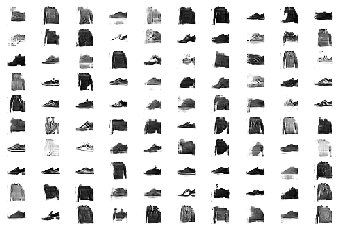

In [5]:
from math import sqrt
from numpy import asarray
from numpy.random import randn
from keras.models import load_model
from matplotlib import pyplot
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_class):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = asarray([n_class for _ in range(n_samples)])
	return [z_input, labels]
 
# create and save a plot of generated images
def save_plot(examples, n_examples):
	# plot images
	for i in range(n_examples):
		# define subplot
		pyplot.subplot(sqrt(n_examples), sqrt(n_examples), 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	pyplot.show()
 
# load model
model = load_model('model_9370.h5')
latent_dim = 100
n_examples = 100 # must be a square
n_class = 7 # sneaker
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
X  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
save_plot(X, n_examples)